# Create Wordlist

Create a lowercase, lightly-cleaned, English language vocabulary list for Autoencoder training.

In [ ]:
import pandas as pd

with pd.HDFStore('../datasets/token-frequencies/token-frequencies-by-language.h5', mode='r') as store:
    df = store.select('/eng', stop=2000000)
len(df)

2000000

Lowercase

In [ ]:
df = df.reset_index()
df['token'] = df.token.str.lower()
df = (df.groupby('token', as_index=False)[['count']].sum()
        .sort_values('count', ascending=False)
     )
df.index = range(1,len(df)+1)
len(df)

1620849

Check against a dictionary of real words.

In [ ]:
import nltk 
nltk.download('words')
word_list = nltk.corpus.words.words()
lower_word_list = set([word.lower() for word in word_list])

[nltk_data] Downloading package words to /home/jovyan/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Rules for finding possible junk

In [ ]:
in_dictionary = df.token.isin(lower_word_list)
hyphenated = df.token.str.contains(r"-")
alpha = df.token.str.isalpha()
basic_number = df.token.str.contains(r"\d")
all_num = df.token.str.contains(r"^\d+$")
number = df.token.str.contains(r"^(£|$|€)?[\d.,]+(st|nd|rd|th|s|C|F|c|m|°|¥)?$")
singlequote = df.token.str.contains(r"[\'’]")
abbr = df.token.str.contains(r"^[^\W\d]([^\W\d]|\.)+$")
endwithperiod = df.token.str.endswith('.')
long_s_or_ligature = df.token.str.contains('(ﬂ|ﬁ|ﬄ|ﬃ|ﬀ|ſ)')
tlen = df.token.str.len()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df['keep'] = in_dictionary
print(df.keep.sum())

# Keep alpha-only words (>2 char)
df.loc[alpha & ~df.keep & (tlen >= 3), 'keep'] = True
print(df.keep.sum())

# Keep longer hyphenated words
df.loc[hyphenated & ~df.keep & (tlen > 3), 'keep'] = True
print(df.keep.sum())

# Include abbreviations, but only the top ones
df.loc[abbr & ~alpha & (tlen >2) & (~df.keep) & (df.index < 35000), 'keep'] = True
print(df.keep.sum())

# Include Top Numbers
df.loc[(~df.keep) & (basic_number) & (number) & (df.index < 10000), 'keep'] = True
print(df.keep.sum())

# Include 4 digit numbers
df.loc[(~df.keep) & (tlen == 4) & (all_num) & (df.index < 30000), 'keep'] = True
print(df.keep.sum())

# Include top <4 digit numbers
df.loc[(~df.keep) & (tlen < 4) & (all_num) & (df.index < 10000), 'keep'] = True
print(df.keep.sum())

# Exclude Short non-alpha matches
df.loc[(tlen == 1) & ~(alpha|all_num),'keep'] = False
print(df.keep.sum())

# Include a few top single-quote chars
df.loc[(~df.keep) & (singlequote) & (df.index < 10000), 'keep'] = True
print(df.keep.sum())

# Remove Ligatures
df.loc[long_s_or_ligature, 'keep'] = False
print(df.keep.sum())

99630
790072
973614
974159
975104
975511
975511
975511
975547
966914


## Calculate character probabilities to help assess realistic long-tail words

In [ ]:
def get_ngrams(s, size=2, pad=False):
    '''
    Split a word into chracter-level ngrams - bigrams by default.
    '''
    if pad:
        # Assuming we're looking at lowercase words, uppercase B
        # and E will pad words to identify begin/end of words
        s = 'B'*(size-1) + s + 'E'*(size-1)
    return [s[i:i+size] for i in range(0, len(s)+1-size)]

Use dictionary words from Numpy for the probabilities, not the messier OCR-derived tokens actually seen in HT.

Word popularity is not included in the probabilities, so 'that' and 'dawg' contribute equally.

In [ ]:
from collections import defaultdict
import numpy as np

counts = defaultdict(int)

for token in lower_word_list:
    trigrams = get_ngrams(token, size=3, pad=True)
    for trigram in trigrams:
        counts[trigram] += 1

trigram_counts = pd.Series(counts).sort_values(ascending=False)
trigram_log_probs = np.log(trigram_counts / trigram_counts.sum()).to_dict()
min_prob = np.min(list(trigram_log_probs.values()))

In [ ]:
def word_probability(s, size=2, pad=False, exp=False, prob_dict=trigram_log_probs, min_prob=min_prob):
    """ Size and Pad should match was was used for the probability dictionary """
    ngrams = get_ngrams(s, size=size, pad=pad)
    probs = []
    for ngram in ngrams:
        if ngram in prob_dict:
            probs.append(prob_dict[ngram])
        else:
            probs.append(min_prob)
    if exp:
        # convert result back to regular probabilities
        return np.exp(np.sum(probs))
    else:
        return np.sum(probs)
    
def avg_word_probability(s, size=2, pad=False, exp=False, prob_dict=trigram_log_probs, min_prob=min_prob):
    """ Get the average character ngram probability for a word"""
    ngrams = get_ngrams(s, size=size, pad=pad)
    probs = []
    for ngram in ngrams:
        if ngram in prob_dict:
            probs.append(prob_dict[ngram])
        else:
            probs.append(min_prob)
    avg_prob = np.mean([np.exp(x) for x in probs])
    if exp:
        return avg_prob
    else:
        return np.log(avg_prob)

In [ ]:
kwargs = dict(size=3, pad=True, prob_dict=trigram_log_probs)
df['avg_prob'] = df.token.apply(lambda x: avg_word_probability(x, **kwargs))
df['prob'] = df.token.apply(lambda x: word_probability(x, **kwargs))

### Plotting Word probabilities

First, see probabilities relative to their rank in the word list.

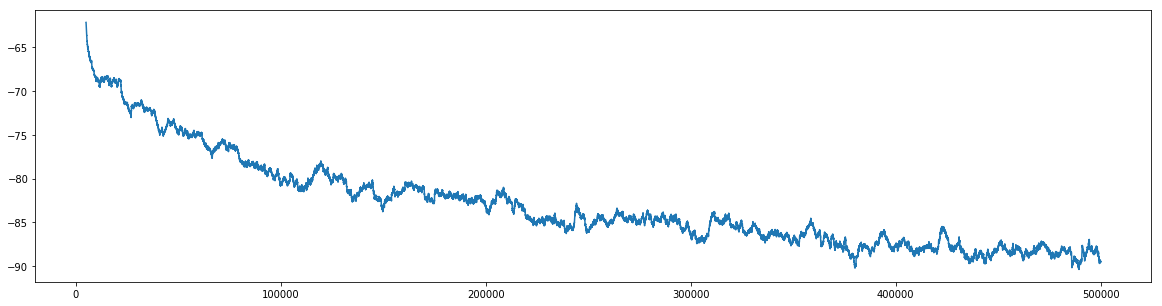

In [ ]:
%matplotlib inline
dist = df.prob[:500000:5].rolling(1000)
dist.mean().plot(figsize=(20,5))

### Dropping by character trigram probabilities

Find the log-probability cutoff that would have excluded 75% of the words that we've already culled. 

For the long tail, words less likely than that cutoff will be dropped.

In [ ]:
cutoff1 = df.loc[~df.keep].avg_prob.quantile(q=0.55)
cutoff2 = df.loc[~df.keep].avg_prob.quantile(q=0.75)
cutoff3 = df.loc[~df.keep].avg_prob.quantile(q=0.85)
cutoff4 = df.loc[~df.keep].avg_prob.quantile(q=0.95)
cutoff5 = df.loc[~df.keep].avg_prob.quantile(q=0.98)
cutoff6 = df.loc[~df.keep].avg_prob.quantile(q=0.99)
cutoff1, cutoff2, cutoff3, cutoff4, cutoff5, cutoff6

(-14.814965275099166,
 -7.093971335299262,
 -6.702917242980172,
 -6.281129524360181,
 -6.044520668408062,
 -5.899279374501542)

Examples of words that will be dropped:

In [ ]:
print(df.loc[(df.index > 100000) & (df.index < 200000) & df.keep & (df.avg_prob <= cutoff1), 'token'].sample(100).tolist())

['ηαβ', '-7.6', '5-44', 'لين', '4-in.', 'ίτοπι', 'هذه', '159-60', '258-259', '83-86', 'وهما', '154-155', '149-151', '55-65', '52-9', '1992-1993', '-13.0', 'ρετ', 'ملأ', '65-5', '12-23', '178-9', '24-48', '1-93', 'اتم', 'ипл', '71-78', '203-4', 'ةها', '20-60', 'ттттт', 'المه', '-20-', '0-83', 'пес', '73-79', 'ιζε', 'ةلم', 'قهقه', '29-2', 'كعك', '---—', '23-0', '1984-86', '193-194', '141-143', '1845-', '147-149', '181-182', 'لهن', '16-31', '21-32', '1968-70', '89-94', '296-297', '1,3-', 'इतन', '2-88', '34-1', 'قلقا', '11-26', 'бег', '176-178', 'узпггггаэ', '29-6', '369-370', '16-9', '(5-6', 'للام', '-0.002', '76-80', 'гон', '60-2', '153-54', 'действие', 'воок', '25-36', '-.....', '57-62', 'ища', 'рарег', '51-0', '153-155', 'خود', '1977-81', '341-342', '81-5', '41-5', '4-51', '4-56', 'ткани', '285-286', '1-61', '161-2', 'ипа', 'типе', '-------.', 'дно', '4-31', 'годы']


In [ ]:
print(df.loc[(df.index > 200000) & (df.index < 300000) & df.keep & (df.avg_prob <= cutoff2), 'token'].sample(100).tolist())

['-350', 'ονοι', 'barzillai', '1933-37', '49-57', '1894-97', 'mittel-', 'janik', 'wasserburg', 'mississipi', 'lovesick', 'laith', 'ncf', 'queensborough', 'janak', '•*->', 'expliqué', 'noordhoff', 'korrektur', 'lahu', '-223', '1893-4.', 'effi', 'kineo', 'guysboro', 'laptev', 'مالها', 'وهالا', 'задачи', 'hs-016', '1873-76', 'вишни', 'zulfikar', 'katoh', ':10-11', 'dmv', 'funck', 'guipuzcoa', 'epw', ',—-a', 'ioooo', 'worh', 'itzzzz', 'origi', 'fmri', 'feltz', 'lollipop', 'holtzclaw', '1939-46', 'ignatieff', 'каждой', 'апн', 'nelli', 'вчч', 'litvinoff', 'laii', 'ellow', 'blaauw', 'дав', '.__-__', 'لمه', '35-year-old', 'akihiko', 'naumkeag', 'oxyhaemoglobin', 'vitreum', 'иск', 'средств', 'оооооо', '8-65', '1944-47', '54-61', 'كلك', 'fook', 'общего', 'όνομα', '-16.1', 'etui', 'frankf', '09-30', 'لالهة', 'ранее', 'nakamoto', 'حلو', 'аые', '85-2', 'vob', '1775-1783', '1954-60', 'है-ट', 'образомъ', '1970-1973', 'enewetak', 'two-loop', '9-93', 'hacerlo', '351-2', 'ايل', 'сош', 'глаза']


Examples of words that will be kept:

In [ ]:
print(df.loc[(df.index > 100000) & (df.index < 200000) & df.keep & (df.avg_prob > cutoff1), 'token'].sample(100).tolist())

['psychotherapist', 'vab', 'tabletop', 'answereth', 'dissector', 'bator', 'factores', 'cently', 'tragédie', 'short-tailed', 'upper-division', 'peor', 'leto', 'gewonnenen', 'leucorrhea', 'dionysios', 'biogeochemistry', 'plaie', 'gephardt', 'versos', 'finisterre', 'mosel', 'moniliform', 'faradization', 'piny', 'anyplace', 'aclu', 'blough', 'phytogeny', 'geber', 'takayama', 'nique', 'empfohlen', 'rascality', 'fluorescens', 'choreographers', 'collaborates', 'proinde', 'ranchman', 'gemachten', 'pentax', 'north-northwest', 'boisterously', 'rowel', 'gradings', 'shapers', 'strobus', 'threlkeld', 'invitational', 'deceitfully', 'lié', 'ouellette', 'paﬅ', 'ganesa', 'elegit', 'annatto', 'dirtier', 'evolutionist', 'sanat', 'disputatio', 'congealing', 'gimp', 'othere', 'self-regulating', 'volumus', '60-inch', 'fragt', 'patin', 'dewe', 'whitelocke', 'hendee', 'poller', 'atis', 'ecially', 'lsaac', 'showmanship', 'lems', 'onslaughts', 'degs', 'backlund', 'benzo', 'syncytium', 'beidler', 'condolences', 

In [ ]:
print(df.loc[(df.index > 200000) & (df.index < 300000) & df.keep & (df.avg_prob > cutoff2), 'token'].sample(100).tolist())

['overburdening', 'prefetch', 'coio', 'poisoners', 'entirelv', 'schuldig', 'disputer', 'verhaltnisse', 'gerl', 'lhis', 'appert', 'víctor', 'aveo', 'amphlett', 'ametek', 'clarki', 'messmore', 'sugi', 'clucked', 'prevalency', 'bossard', 'tischer', 'burgas', 'battaile', 'nonionizing', 'true-love', 'brhaspati', 'postexposure', 'thalassia', 'glycogenic', 'cross-disciplinary', 'culhane', 'interet', 'aortography', 'exorbitantly', 'schachner', 'drawdowns', 'cafés', 'stohr', 'heymans', 'oppel', 'inhomogeneously', 'sisymbrium', 'orchestrating', 'titanates', 'rusi', 'stunkard', 'decedest', 'ntd', 'an-1', 'carbutt', 'arborvitae', 'trichromatic', 'tpke', 'amorpha', 'flexuose', 'otel', 'fastidiously', 'sub-assistant', 'déposés', 'tuberk', 'hedy', 'cephaloridine', 'numeros', 'abcs', 'acanthamoeba', 'prodns', 'rictus', 'cebes', 'landt', 'absent-mindedly', 'khode', 'hypnotize', 'baluze', 'sabel', 'oestrone', 'jedesmal', 'caulker', 'andren', 'prefervation', 'waltair', 'anicetus', 'boshes', 'monteil', 'k

Looks fine. Cull, cull, cull!

In [ ]:
# So I can back up!
keep = df.keep.copy()

In [ ]:
df.keep = keep.copy()
df.loc[(df.index > 50000) & df.keep & (df.avg_prob <= cutoff1), 'keep'] = False
print(df.keep.sum())
df.loc[(df.index > 100000) & df.keep & (df.avg_prob <= cutoff2), 'keep'] = False
print(df.keep.sum())
df.loc[(df.index > 200000) & df.keep & (df.avg_prob <= cutoff3), 'keep'] = False
print(df.keep.sum())
df.loc[(df.index > 250000) & df.keep & (df.avg_prob <= cutoff4), 'keep'] = False
print(df.keep.sum())
df.loc[(df.index > 300000) & df.keep & (df.avg_prob <= cutoff5), 'keep'] = False
print(df.keep.sum())
df.loc[(df.index > 350000) & df.keep & (df.avg_prob <= cutoff6), 'keep'] = False
print(df.keep.sum())

857541
755295
620716
360203
243132
202498


One last check: which words are in the NLTK dictionary but that will be dropped?

In [ ]:
missing = df[~df.keep & df.token.isin(lower_word_list)]
print(len(missing))
print(missing.sample(100).token.tolist())

42839
['godlikeness', 'cladothrix', 'tarsonemidae', 'warmongering', 'unexcepted', 'heatstroke', 'barrelhead', 'niyoga', 'retardment', 'helvella', 'loanword', 'oxter', 'beestings', 'tantalic', 'scrounging', 'marang', 'unagreed', 'cushy', 'galactorrhea', 'antistreptococcic', 'tanked', 'engram', 'lupercal', 'discriminable', 'saltwort', 'tocharian', 'antinarcotic', 'sexagenary', 'meshwork', 'hydrohalide', 'proseminary', 'termor', 'zamia', 'nonmedicinal', 'floriculturist', 'unloveliness', 'isotria', 'procommunist', 'hybridation', 'snapback', 'gaeldom', 'argasidae', 'claytonia', 'myrmecophilous', 'tramper', 'merak', 'antennary', 'neper', 'cardiidae', 'cerulein', 'micrography', 'nonstandardized', 'toxication', 'acritical', 'phrenetic', 'wanty', 'alkalimeter', 'unsprinklered', 'pushover', 'repeople', 'atticist', 'inappetence', 'schnorrer', 'unpreaching', 'drawspan', 'pyrrhonist', 'renunciatory', 'womanizer', 'mediad', 'benben', 'praxitelean', 'humbuggery', 'subdelegation', 'kallima', 'yponomeu

Fun words! But likely fine to lose.

# Review

At this point, I'm trying to manually review how much of the remaining list is necessary to keep.

Roughly, Im finding:

- 100-120k is sparsely useful words
- 120-140k is rarely useful
- 140k-160k is very rarely useful - anything after 140k is usually fine to drop.

In [ ]:
start, end = 140000, 160000
sample = df[(df.keep)][start:end].sample(100).token.tolist()
print(sample)

['serpa', 'gustine', 'mycin', 'umbilicate', 'clewell', 'banneret', 'sedgy', 'palish', 'pvs', 'feot', 'schweppes', 'granja', 'bestselling', 'homesteaded', 'many-electron', 'vailing', 'adhemar', 'marchbanks', 'affiftance', 'radionavigation', 'enceladus', 'polymerizable', 'etrangere', 'longer-range', 'apodemus', 'czernin', 'sja', 'wordplay', 'anuales', 'cross-reactive', 'tycoons', 'calyxes', 'centaury', 'sirhind', 'phcebus', 'cicatrisation', 'cerc', 'nmd', 'fermée', 'statuti', 'microspore', 'bvd', 'calendario', 'unrealizable', 'berd', 'deliverables', 'wone', 'journee', 'bloodied', 'demott', 'stls', 'hentschel', 'sonthern', 'nolite', 'hollon', 'skane', 'ergy', 'fupplied', 'sixte', 'lliey', 'ignorantia', 'spoile', 'fairbridge', 'rcent', 'poto', 'syke', 'fridman', 'augustins', 'soccage', 'anti-pope', 'crosspiece', 'poteet', 'unestablished', 'inspectional', 'proleg', 'composant', 'initiales', 'chora', 'sherrick', 'cruelle', 'martire', 'provirus', 'bilharziasis', 'wouters', 'fluoranthene', 'uk

## Save final list

In [ ]:
final = df.loc[df.keep, 'token'].copy()
final.index = range(1, len(final)+1)
final.head()

1    the
2     of
3    and
4     to
5     in
Name: token, dtype: object

In [ ]:
final.to_csv('eng-vocab-1.txt.bz2', index=False, header=False, compression='bz2')

### Example Read

In [ ]:
test = pd.read_csv('eng-vocab-1.txt.bz2', names=['token'])
test.head()

,token
0,the
1,of
2,and
3,to
4,in
